# EECE5644 Assignment 3 - Question 1

## Description
Implementation of multi-layer perceptron classification with 10-fold cross-validation for model order selection. Trains MLPs on 4-class Gaussian data with varying training set sizes (100-10,000 samples) and compares performance against the theoretically optimal MAP classifier using true distribution parameters.

## Table of Contents
1. Setup & Imports
2. Helper Functions
3. MLP Model Setup, Training, & Evaluation
4. Experiment Pipeline

## 1. Setup & Imports

Import required libraries and set random seeds for reproducibility.

### Contents
- 1.1 Imports  
- 1.2 Random Seed

In [ ]:
# @title 1.1 Imports

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal

tf.get_logger().setLevel('ERROR')

In [2]:
# @title 1.2 Random Seed
np.random.seed(42)
tf.random.set_seed(42)

## 2. Helper Functions

Utility functions for generating Gaussian mixture data and evaluating the theoretical optimal MAP classifier performance.

### Contents
- 2.1 Data Generation Function  
- 2.2 Theoretical Optimal Evaluation Function

In [3]:
# @title 2.1 Data Generation Function

def generate_data(
  n: int,
  means: np.ndarray,
  covs: np.ndarray,
  priors: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
  """
  Generate n samples from a 4-class Gaussian mixture.

  Args:
    n: Number of samples to generate.
    means: (4, 3) array of class means.
    covs: (4, 3, 3) array of class covariance matrices.
    priors: (4,) array of class priors (should sum to 1).

  Returns:
    x: (n, 3) array of generated data samples.
    y: (n,) array of class labels (0, 1, 2, 3).
  """
  num_classes = len(priors)
  dim = means.shape[1]

  x = np.zeros((n, dim))
  y = np.zeros(n, dtype=int)

  for i in range(n):
    # choose class according to priors
    class_idx = np.random.choice(num_classes, p=priors)
    y[i] = class_idx

    # generate sample from selected class
    x[i] = np.random.multivariate_normal(means[class_idx], covs[class_idx])

  return x, y

In [4]:
# @title 2.2 Theoretical Optimal Evaluation Function

def evaluate_theoretical_optimal(
  x: np.ndarray,
  y_true: np.ndarray,
  means: np.ndarray,
  covs: np.ndarray,
  priors: np.ndarray
) -> float:
  """
  Evaluate MAP classifier using the true data distribution.

  Args:
    x: (n, 3) array of test data samples.
    y_true: (n,) array of true class labels.
    means: (k, 3) array of class means.
    covs: (k, 3, 3) array of class covariance matrices.
    priors: (k,) array of class priors (should sum to 1).

  Returns:
    error_rate: Probability of classification error.
  """
  n = x.shape[0]
  num_classes = len(priors)

  # compute class posteriors for each sample
  posteriors = np.zeros((n, num_classes))
  for c in range(num_classes):
    posteriors[:, c] = priors[c] * multivariate_normal.pdf(x, means[c], covs[c])

  # normalize to get posteriors
  posteriors = posteriors / posteriors.sum(axis=1, keepdims=True)

  # MAP decision rule
  y_pred = np.argmax(posteriors, axis=1)

  error_rate = np.mean(y_pred != y_true)
  return float(error_rate)

## 3. MLP Model Setup, Training, & Evaluation

Functions for creating, training, and evaluating MLP models with ELU activation. Includes cross-validation for model order selection and multiple random initializations to avoid local optima.

### Contents
- 3.1 MLP Model Creation Function  
- 3.2 MLP Model Training Function  
- 3.3 MLP Model Evaluation Function  
- 3.4 Cross-Validation Function

In [17]:
# @title 3.1 MLP Model Creation Function

def create_mlp(
  input_dim: int,
  hidden_dim: int,
  output_dim: int,
  lr: float = 0.01
) -> keras.Model:
  """
  Create an MLP model with one hidden layer.
  Uses ELU activation (smooth-ramp style).

  Args:
    input_dim: Input feature dimension.
    hidden_dim: Number of neurons in the hidden layer.
    output_dim: Number of output classes.
    lr: Learning rate.

  Returns:
    A compiled Keras model.
  """
  model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(hidden_dim, activation='elu'),
    layers.Dense(output_dim, activation='softmax')
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [18]:
# @title 3.2 MLP Model Training Function

def train_mlp(
  model: keras.Model,
  x_train: np.ndarray,
  y_train: np.ndarray,
  epochs: int = 100,
  batch_size: int = 64,
  verbose: int = 0
) -> keras.Model:
  """
  Train an MLP model.

  Args:
    model: A compiled Keras model.
    x_train: Training data.
    y_train: Training labels.
    epochs: Number of training epochs.
    batch_size: Batch size.
    verbose: Verbosity level for training output.

  Returns:
    The trained Keras model.
  """
  # early stopping
  early_stop = keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
  )

  model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=verbose,
    callbacks=[early_stop]
  )

  return model

In [19]:
# @title 3.3 MLP Model Evaluation Function

def evaluate_model(
  model: keras.Model,
  x: np.ndarray,
  y: np.ndarray
) -> float:
  """
  Evaluate model accuracy.

  Args:
    model: Trained Keras model.
    x: Data samples.
    y: True labels.

  Returns:
    error_rate: Classification error rate.
  """
  predictions = model.predict(x, verbose=0)
  y_pred = np.argmax(predictions, axis=1)
  error_rate = np.mean(y_pred != y)
  return float(error_rate)

In [20]:
# @title 3.4 Cross Validation Function

def cross_validate_perceptrons(
  x: np.ndarray,
  y: np.ndarray,
  p_candidates: list[int],
  k_folds: int = 10,
  epochs: int = 100
) -> tuple[int, np.ndarray]:
  """
  Perform k-fold cross-validation to select the best number of perceptrons.
  Minimizes TensorFlow retracing by clearing sessions efficiently.

  Args:
    x: Training data.
    y: Training labels.
    p_candidates: List of perceptron counts to try.
    k_folds: Number of cross-validation folds.
    epochs: Number of training epochs per model.

  Returns:
    best_p: Optimal number of perceptrons.
    mean_cv_errors: Average CV error for each P value.
  """
  mean_cv_errors = []

  print(f"    Testing {len(p_candidates)} perceptron values...")

  # define kfold
  kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

  for p in p_candidates:
    fold_errors = []
    print(f"      P={p:2d}: ", end='', flush=True)

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(x), start=1):
      # clear previous TF graph
      keras.backend.clear_session()

      x_train, x_val = x[train_idx], x[val_idx]
      y_train, y_val = y[train_idx], y[val_idx]

      # create and train model
      model = create_mlp(input_dim=3, hidden_dim=p, output_dim=4)
      model = train_mlp(model, x_train, y_train, epochs=epochs, verbose=0)

      # evaluate on validation set
      error = evaluate_model(model, x_val, y_val)
      fold_errors.append(error)

      print('.', end='', flush=True)

    mean_error = np.mean(fold_errors)
    mean_cv_errors.append(mean_error)
    print(f' Avg Error={mean_error:.4f}')

  # select best
  best_idx = np.argmin(mean_cv_errors)
  best_p = p_candidates[best_idx]

  return best_p, np.array(mean_cv_errors)


In [21]:
# @title Train MLP w/ Reinitialization Function

def train_mlp_with_reinitialization(
  x: np.ndarray,
  y: np.ndarray,
  p: int,
  num_inits: int = 5,
  epochs: int = 100
) -> keras.Model:
  """
  Train an MLP with multiple random initializations and keep the best model.

  Args:
    x: Training data.
    y: Training labels.
    p: Number of perceptrons in the hidden layer.
    num_inits: Number of random initializations.
    epochs: Number of training epochs.

  Returns:
    best_model: Trained model with the lowest training error.
  """
  best_error = np.inf
  best_model = None

  for init in range(num_inits):
    # random seed
    tf.random.set_seed(init)
    np.random.seed(init)

    # create and train model
    model = create_mlp(input_dim=3, hidden_dim=p, output_dim=4)
    model = train_mlp(model, x, y, epochs=epochs, verbose=0)

    # evaluate
    error = evaluate_model(model, x, y)

    if error < best_error:
      best_error = error
      best_model = model
    else:
      # clean up
      keras.backend.clear_session()

  return best_model


## 4. Experiment Pipeline

This section executes the complete experimental procedure including data generation,
theoretical baseline evaluation, cross-validation-based model selection, and final
model training across multiple training set sizes.

### Contents
- 4.1 Configuration
- 4.2 Generation
- 4.3 Theoretical Optimal Classifier
- 4.4 Model Order Selection & Training
- 4.5 Results Summary
- 4.6 Visualization

In [22]:
# @title 4.1 Configuration

# means
means = np.array([
  [0, 0, 0],
  [2.5, 2.5, 0],
  [0, 2.5, 2.5],
  [2.5, 0, 2.5]
])

# covariance matrices
c1 = np.eye(3) * 1.5
c2 = np.eye(3) * 1.5
c3 = np.array([[1.8, 0.3, 0.3], [0.3, 1.8, 0.3], [0.3, 0.3, 1.8]])
c4 = np.array([[1.8, -0.3, 0], [-0.3, 1.8, 0], [0, 0, 1.8]])
covs = np.array([c1, c2, c3, c4])

# uniform priors
priors = np.array([0.25, 0.25, 0.25, 0.25])

In [23]:
# @title 4.2 Generation

training_sizes = [100, 500, 1000, 5000, 10000]
test_size = 100000

print("\nGenerating datasets...")
x_test, y_test = generate_data(test_size, means, covs, priors)
print(f"  Test set: {test_size} samples")

training_sets = []
for n in training_sizes:
    x, y = generate_data(n, means, covs, priors)
    training_sets.append({'x': x, 'y': y, 'n': n})
    print(f"  Training set: {n} samples")


Generating datasets...
  Test set: 100000 samples
  Training set: 100 samples
  Training set: 500 samples
  Training set: 1000 samples
  Training set: 5000 samples
  Training set: 10000 samples


In [24]:
# @title 4.3 Theoretical Optimal Classifier

print("\nComputing theoretically optimal classifier performance...")
theoretical_error = evaluate_theoretical_optimal(x_test, y_test, means, covs, priors)
print(f"Theoretical optimal P(error) = {theoretical_error:.4f}\n")


Computing theoretically optimal classifier performance...
Theoretical optimal P(error) = 0.1875



In [25]:
# @title 4.4 Model Order Selection & Training

p_candidates = [1, 2, 3, 5, 7, 10, 15, 20]
k_folds = 10
num_random_inits = 5
epochs = 100

best_p_values = []
trained_models = []
test_errors = []

for i, train_set in enumerate(training_sets):
    n = train_set['n']
    x_train = train_set['x']
    y_train = train_set['y']

    print(f"\nProcessing training set with N={n} samples...")

    # cross-validation
    print("  Running 10-fold cross-validation...")
    best_p, cv_errors = cross_validate_perceptrons(
        x_train, y_train, p_candidates, k_folds, epochs
    )
    best_p_values.append(best_p)
    print(f"  Best P = {best_p} perceptrons")

    # train final model with best P
    print(f"  Training final model with P={best_p}...")
    final_model = train_mlp_with_reinitialization(x_train, y_train, best_p, num_random_inits, epochs)
    trained_models.append(final_model)

    # evaluate on test set
    test_error = evaluate_model(final_model, x_test, y_test)
    test_errors.append(test_error)
    print(f"  Test P(error) = {test_error:.4f}")


Processing training set with N=100 samples...
  Running 10-fold cross-validation...
    Testing 8 perceptron values...
      P= 1: .......... Avg Error=0.4900
      P= 2: .......... Avg Error=0.3700
      P= 3: .......... Avg Error=0.2300
      P= 5: .......... Avg Error=0.2300
      P= 7: .......... Avg Error=0.1700
      P=10: .......... Avg Error=0.1900
      P=15: .......... Avg Error=0.2100
      P=20: .......... Avg Error=0.2100
  Best P = 7 perceptrons
  Training final model with P=7...
  Test P(error) = 0.1998

Processing training set with N=500 samples...
  Running 10-fold cross-validation...
    Testing 8 perceptron values...
      P= 1: .......... Avg Error=0.5020
      P= 2: .......... Avg Error=0.2820
      P= 3: .......... Avg Error=0.1540
      P= 5: .......... Avg Error=0.1440
      P= 7: .......... Avg Error=0.1480
      P=10: .......... Avg Error=0.1500
      P=15: .......... Avg Error=0.1420
      P=20: .......... Avg Error=0.1400
  Best P = 20 perceptrons
  Trainin

In [26]:
# @title 4.5 Results Summary

print(f"Theoretical Optimal P(error): {theoretical_error:.4f}\n")
print("Training Size | Best P | Test P(error)")
print("--------------|--------|-------------")
for i, n in enumerate(training_sizes):
    print(f"{n:12d}  | {best_p_values[i]:6d} | {test_errors[i]:.4f}")

Theoretical Optimal P(error): 0.1875

Training Size | Best P | Test P(error)
--------------|--------|-------------
         100  |      7 | 0.1998
         500  |     20 | 0.1912
        1000  |     15 | 0.1907
        5000  |      7 | 0.1911
       10000  |      5 | 0.1883


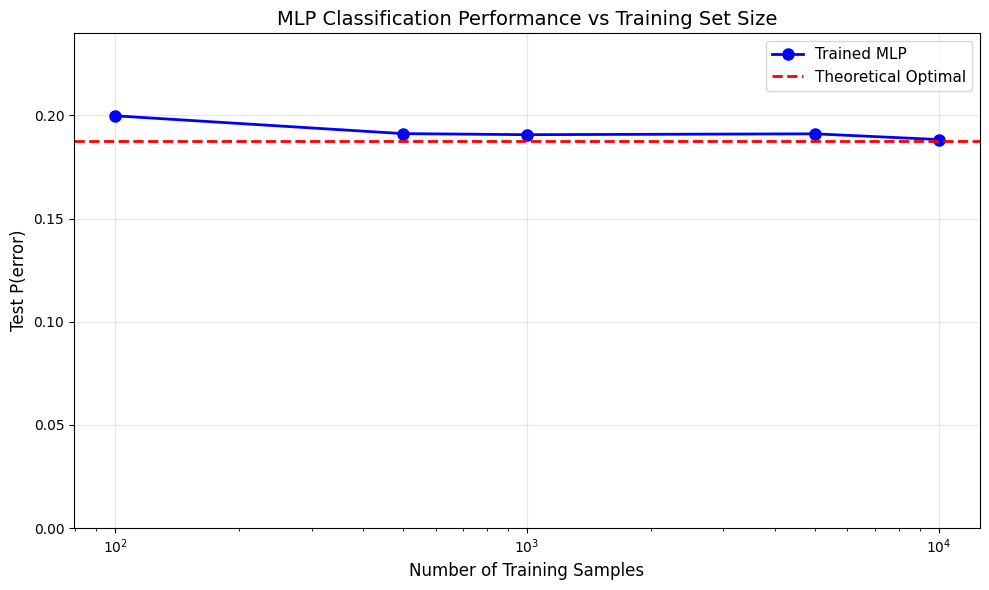

In [27]:
# @title 4.6 Visualization

plt.figure(figsize=(10, 6))
plt.semilogx(training_sizes, test_errors, 'bo-', linewidth=2, markersize=8, label='Trained MLP')
plt.axhline(y=theoretical_error, color='r', linestyle='--', linewidth=2, label='Theoretical Optimal')
plt.grid(True, alpha=0.3)
plt.xlabel('Number of Training Samples', fontsize=12)
plt.ylabel('Test P(error)', fontsize=12)
plt.title('MLP Classification Performance vs Training Set Size', fontsize=14)
plt.legend(fontsize=11)
plt.ylim([0, max(test_errors + [theoretical_error]) * 1.2])
plt.tight_layout()
plt.show()